# **Install the Required Library and Packages**

In [ ]:
!python3 --version

Python 3.10.12


In [ ]:
!pip install -q tensorflow scikit-learn pillow matplotlib

In [ ]:
!pip install tflite-support
!pip install --upgrade tensorflow tensorflow-lite-support


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement tensorflow-lite-support (from versions: none)
ERROR: No matching distribution found for tensorflow-lite-support


### Import the Library and Packages

 After all the required library and packages installed, import the library and the packages. If there's an error, try to rerun the code

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from PIL import Image
from tflite_support.metadata_writers import writer_utils
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import metadata_info

# **Preparing The Data**

### Google Drive Mount

Connects your Google Drive to the Colab environment so you can use files stored there.


In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


### Download Dataset

Downloads the dataset directly from Google Drive using a specific ID for the dataset.

In [ ]:
!gdown 1LuRtTPlCUq_a2PR10UXu5kpU7ATldElU

Downloading...
From (original): https://drive.google.com/uc?id=1LuRtTPlCUq_a2PR10UXu5kpU7ATldElU
From (redirected): https://drive.google.com/uc?id=1LuRtTPlCUq_a2PR10UXu5kpU7ATldElU&confirm=t&uuid=68e41deb-11bd-400b-a5f9-7381e11e8831
To: /content/[C241-PS314]Ageman-Datasets.zip
100% 897M/897M [00:12<00:00, 73.7MB/s]


### Extract The Data

Unzips the downloaded dataset so we can use the image files inside.

In [ ]:
# Extract Dataset
!unzip /content/[C241-PS314]Ageman-Datasets.zip

Archive:  /content/[C241-PS314]Ageman-Datasets.zip
  inflating: Dataset-ageman/Kecak/valid/jalurrempah.kemdikbudgoid.webp  
  inflating: Dataset-ageman/Kecak/valid/Tari-kecak-Bali-2.jpg  
  inflating: Dataset-ageman/Barong/test/IMG_3145.jpg  
  inflating: Dataset-ageman/Barong/test/IMG_2955.jpg  
  inflating: Dataset-ageman/Barong/test/IMG_3143.jpg  
  inflating: Dataset-ageman/Barong/test/IMG_3146.jpg  
  inflating: Dataset-ageman/Baris/valid/Baris-Dance-Enlarged_jpg.rf.0dcaef8d0454a2ff42fc82f93930c93c.jpg  
  inflating: Dataset-ageman/Kecak/valid/664ecbffc3c3d.jpg  
  inflating: Dataset-ageman/Baris/valid/tari-baris-1-_jpg.rf.ccc227ee7cc0dd23d953915fe877b566.jpg  
  inflating: Dataset-ageman/Barong/test/IMG_2938.jpg  
  inflating: Dataset-ageman/Barong/test/its-expo-04.jpg  
  inflating: Dataset-ageman/Baris/valid/images-3-_jpg.rf.14f26b6993520241f5764ff41fecd45e.jpg  
  inflating: Dataset-ageman/Barong/test/IMG_3147.jpg  
  inflating: Dataset-ageman/Kecak/test/IMG_3113.jpg  
  infla

# **Exploratory Data Analysis**

### Data Distribution

Shows how many images there are for each category in the training data using a bar chart. The data is split into 90% for training, 5% for validation, and 5% for testing to ensure the model has sufficient data to learn and also to evaluate its performance accurately.

Train set: 1592 images
Validation set: 84 images
Test set: 91 images


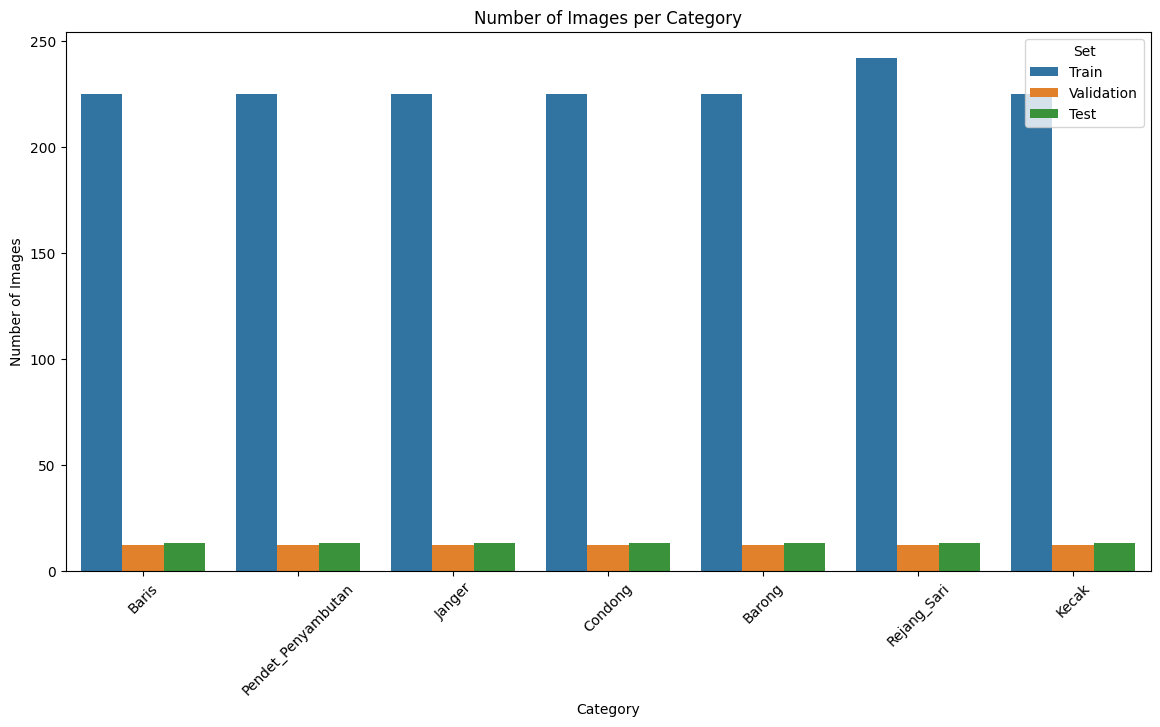

In [ ]:
dataset_dir = '/content/Dataset-ageman'

def count_images(folder):
    return sum([len(files) for r, d, files in os.walk(folder) if any(files)])

labels = os.listdir(dataset_dir)

# Count the number of images in each set for each label
train_label_counts = {label: count_images(os.path.join(dataset_dir, label, 'train')) if 'train' in os.listdir(os.path.join(dataset_dir, label)) else 0 for label in labels}
val_label_counts = {label: count_images(os.path.join(dataset_dir, label, 'valid')) if 'valid' in os.listdir(os.path.join(dataset_dir, label)) else 0 for label in labels}
test_label_counts = {label: count_images(os.path.join(dataset_dir, label, 'test')) if 'test' in os.listdir(os.path.join(dataset_dir, label)) else 0 for label in labels}

# Print total counts
train_count = sum(train_label_counts.values())
val_count = sum(val_label_counts.values())
test_count = sum(test_label_counts.values())

print(f'Train set: {train_count} images')
print(f'Validation set: {val_count} images')
print(f'Test set: {test_count} images')

# Combine all count into one DataFrame
data = {
    'Label': labels,
    'Train': [train_label_counts[label] for label in labels],
    'Validation': [val_label_counts[label] for label in labels],
    'Test': [test_label_counts[label] for label in labels]
}

df = pd.DataFrame(data)

# Visualize Data Distribution
plt.figure(figsize=(14, 7))
df_melted = df.melt(id_vars=['Label'], var_name='Set', value_name='Count')
sns.barplot(x='Label', y='Count', hue='Set', data=df_melted)
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

### Load the Dataset

Loads and displays a sample image from the training data to see what our images look like.

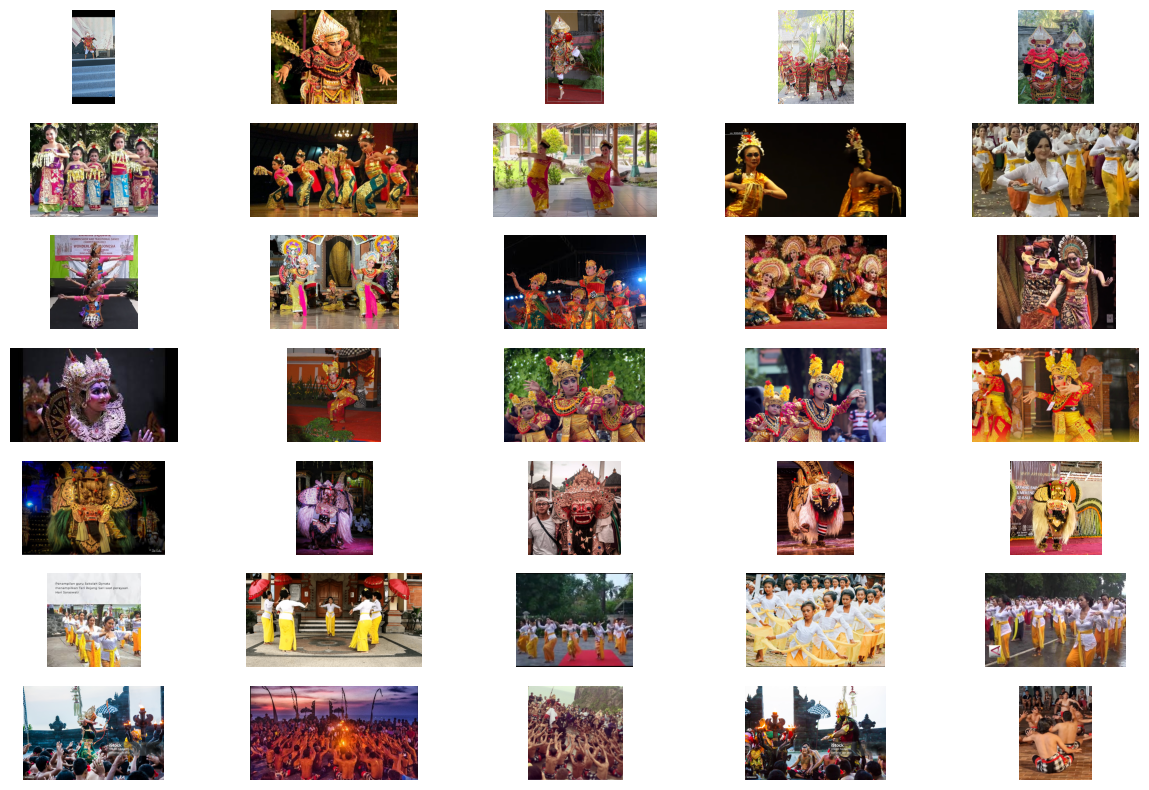

In [ ]:
# Show Data
def show_sample_images(dataset_dir, labels, samples_per_label=5):
    plt.figure(figsize=(15, 10))
    for i, label in enumerate(labels):
        folder = os.path.join(dataset_dir, label, 'train')
        images = os.listdir(folder)[:samples_per_label]
        for j, image in enumerate(images):
            img = Image.open(os.path.join(folder, image))
            plt.subplot(len(labels), samples_per_label, i * samples_per_label + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.ylabel(label, size=100)
    plt.show()

show_sample_images(dataset_dir, labels)

### Data Augmentation

Creates new, slightly modified versions of the training images to help our model learn better and become more robust.

In [ ]:
# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Path to direktori dataset
dataset_dir = '/content/Dataset-ageman'

# Create directory paths for each set
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'valid')
test_dir = os.path.join(dataset_dir, 'test')

# Create directories for train, valid, and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move label subdirectories to the corresponding set directories
for label in os.listdir(dataset_dir):
    if os.path.isdir(os.path.join(dataset_dir, label)):
        if 'train' in os.listdir(os.path.join(dataset_dir, label)):
            os.rename(os.path.join(dataset_dir, label, 'train'), os.path.join(train_dir, label))
        if 'valid' in os.listdir(os.path.join(dataset_dir, label)):
            os.rename(os.path.join(dataset_dir, label, 'valid'), os.path.join(val_dir, label))
        if 'test' in os.listdir(os.path.join(dataset_dir, label)):
            os.rename(os.path.join(dataset_dir, label, 'test'), os.path.join(test_dir, label))


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 1540 images belonging to 7 classes.
Found 81 images belonging to 7 classes.
Found 85 images belonging to 7 classes.


# **Build and Train Model**

### Creating CNN Model

Defines the structure of the Convolutional Neural Network (CNN), specifying layers and their types. Compiles the model with an optimizer and prints out the model details.

In [ ]:
from keras.callbacks import ModelCheckpoint

# Folder for save model
checkpoint_dir = '/content/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'best_ageman_model.h5')

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [ ]:
# Build an CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 37, 37, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       7

### Train the Model

Trains the CNN on the training images while using validation data to check how well the model is doing. Uses techniques to adjust training speed, stop early if needed, and save the best version of the model.

In [15]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint_callback]
)

Epoch 1/100
 5/49 [==>...........................] - ETA: 2:42 - loss: 4.7620 - accuracy: 0.1562

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


49/49 [==============================] - ETA: 0s - loss: 2.2470 - accuracy: 0.1468
Epoch 1: val_accuracy improved from -inf to 0.14815, saving model to /content/checkpoints/best_ageman_model.h5
49/49 [==============================] - 146s 3s/step - loss: 2.2470 - accuracy: 0.1468 - val_loss: 1.9357 - val_accuracy: 0.1481
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 1.9311 - accuracy: 0.1838
Epoch 2: val_accuracy did not improve from 0.14815
49/49 [==============================] - 135s 3s/step - loss: 1.9311 - accuracy: 0.1838 - val_loss: 1.9458 - val_accuracy: 0.1481
Epoch 3/100
49/49 [==============================] - ETA: 0s - loss: 1.9185 - accuracy: 0.2032
Epoch 3: val_accuracy improved from 0.14815 to 0.22222, saving model to /content/checkpoints/best_ageman_model.h5
49/49 [==============================] - 134s 3s/step - loss: 1.9185 - accuracy: 0.2032 - val_loss: 1.8299 - val_accuracy: 0.2222
Epoch 4/100
49/49 [==============================] - ETA: 0s 

### Model Evaluation

Tests how well the trained model performs on unseen test data and visualizes the training and validation performance over time.

3/3 [==============================] - 2s 550ms/step - loss: 0.6281 - accuracy: 0.8765
Test Accuracy: 87.65%


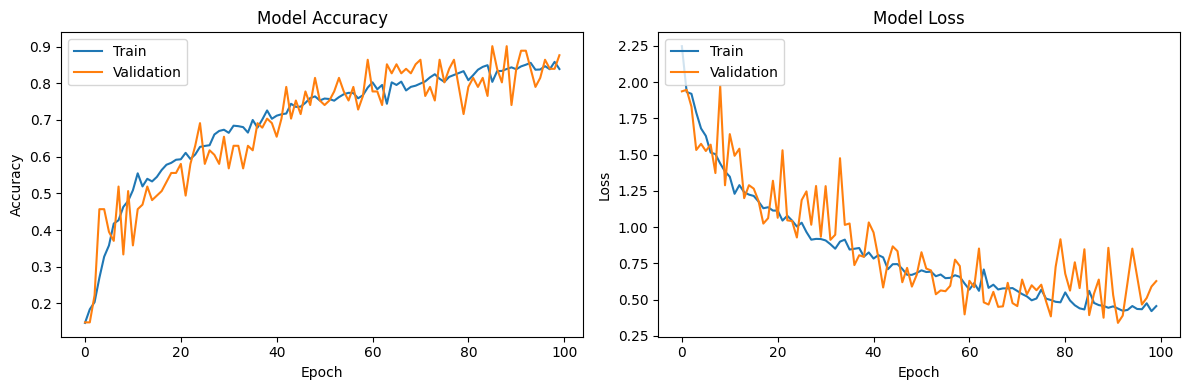

In [16]:
# Model Evaluation
loss, accuracy = model.evaluate(val_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# **Save Model**

Converts the trained model into a lightweight format (TensorFlow Lite) that can be used on mobile devices or edge devices.

In [17]:
# Save model
model.save('ageman_model.h5')
model.load_weights('/content/checkpoints/best_ageman_model.h5')

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open('ageman_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Save model TFLite
with open('/content/checkpoints/best_ageman_model.tflite', 'wb') as f:
    f.write(tflite_model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
labels = ['Baris', 'Barong', 'Condong', 'Janger', 'Kecak', 'Pendet_Penyambutan', 'Rejang_Sari']

with open('labels.txt', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

In [19]:
# Path to the TensorFlow Lite model
tflite_model_path = '/content/ageman_model.tflite'

# Path where the metadata-enriched model will be saved
tflite_model_with_metadata_path = '/content/ageman_model_with_metadata.tflite'

# Create ImageClassifier metadata writer
writer = image_classifier.MetadataWriter.create_for_inference(
    writer_utils.load_file(tflite_model_path),
    input_norm_mean=[0],
    input_norm_std=[1],
    label_file_paths=['labels.txt']
)

# Populate the metadata into the model
writer_utils.save_file(writer.populate(), tflite_model_with_metadata_path)

print("Metadata has been successfully added to the TensorFlow Lite model.")

Metadata has been successfully added to the TensorFlow Lite model.


# **Test the Model**

### Testing with Test Image

Loads the TensorFlow Lite model and tests it with a new image to see its prediction.

In [ ]:
interpreter = tf.lite.Interpreter(model_path='ageman_model_with_metadata.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB').resize((150, 150))
    img = np.array(img, dtype=np.float32)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def display_prediction(image_path, prediction, labels, threshold=70):
    img = Image.open(image_path)
    confidence = np.max(prediction) * 100
    predicted_label = labels[np.argmax(prediction)]

    # Show prediction with or without percentage based on the threshold
    if confidence < threshold:
        plt.title('Unknown')
    else:
        plt.title(f'{confidence:.2f}% {predicted_label}')

    plt.imshow(img)
    plt.axis('off')
    plt.show()

test_dir = '/content/Dataset-ageman/test'

test_images = []
for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):
        for img_file in os.listdir(label_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                test_images.append(os.path.join(label_dir, img_file))

labels = ['Baris', 'Barong', 'Condong', 'Janger', 'Kecak', 'Pendet_Penyambutan', 'Rejang_Sari']

for image_path in test_images:
    try:
        input_data = preprocess_image(image_path)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Show prediction
        display_prediction(image_path, output_data, labels)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

In [ ]:
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='ageman_model_with_metadata.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB').resize((150, 150))
    img = np.array(img, dtype=np.float32)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Display prediction
def display_prediction(image_path, prediction, labels, threshold=70):
    img = Image.open(image_path)
    prediction_percentages = prediction.flatten() * 100
    predicted_labels = [f'{label}: {percentage:.2f}%' for label, percentage in zip(labels, prediction_percentages)]

    plt.imshow(img)
    plt.axis('off')
    plt.title('\n'.join(predicted_labels))
    plt.show()


# Specify the path of the image you want to test
image_path = '/content/komeng.jpeg'

# Preprocess the image
input_data = preprocess_image(image_path)

# Set the input tensor with the preprocessed image data
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Define your labels
labels = ['Baris', 'Barong', 'Condong', 'Janger', 'Kecak', 'Pendet_Penyambutan', 'Rejang_Sari']

# Show prediction
display_prediction(image_path, output_data, labels)

### Test Best Performance Tflite Model

Loads the best version of the saved model, converts it to TensorFlow Lite, and tests it with a new image to check its prediction.

In [ ]:
interpreter = tf.lite.Interpreter(model_path='/content/ageman_model_with_metadata.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB').resize((150, 150))
    img = np.array(img, dtype=np.float32)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def display_prediction(image_path, prediction, labels):
    img = Image.open(image_path)
    predicted_label = labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{confidence:.2f}% {predicted_label}')
    plt.show()

test_dir = '/content/Dataset-ageman/test'

test_images = []
for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):
        for img_file in os.listdir(label_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                test_images.append(os.path.join(label_dir, img_file))

labels = ['Baris', 'Barong', 'Condong', 'Janger', 'Kecak', 'Pendet_Penyambutan', 'Rejang_Sari']


for image_path in test_images:
    try:
        input_data = preprocess_image(image_path)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Show prediction
        display_prediction(image_path, output_data, labels)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")